 # Сингулярное разложение

Одно из наиболее прикладных свойств сингулярного разложения заключается (неформально) в представлении данных большой размерности данными меньшей размерности. Приведём пример. Пусть матрица $A$ кодирует некие данные в своих столбцах и $V S U^t$ — это сингулярное разложение $A$. Для многих типов данных первые $k$ сингулярных чисел (где $k \in \mathbb{N}$) и соответствующие им $k$ столбцов матриц $V$ и $U$ отражают «главные» особенности этих данных, какие удаётся захватить размерностью $k$. Например, если $A$ является изображением, то после обнуления всех столбцов $V$ и $U$, кроме первых $k$, и всех сингулярных чисел, кроме первых $k$, полученная матрица $V S U^t$ ранга ${\le}k$ будет «приближённо» кодировать изображение; это изображение обычно остаётся узнаваемым даже при малых $k$ и таким образом можно делать сжатие картинок (в примере $k = 20$):

C:\Users\nooas\AppData\Local\Temp\ipykernel_26716\1560260260.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  V, S, Ut = np.linalg.svd(imageio.imread('urfu-mini.png', pilmode='L'))


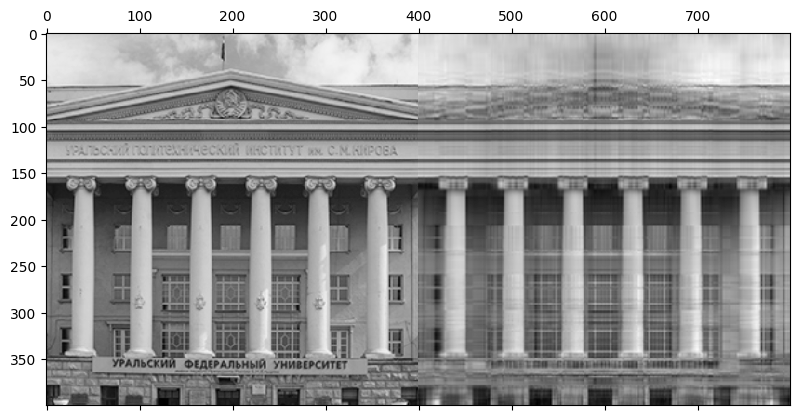

In [1]:
import numpy as np, matplotlib.pyplot as plt, imageio
V, S, Ut = np.linalg.svd(imageio.imread('urfu-mini.png', pilmode='L'))
original, compressed = V @ np.diag(S) @ Ut, V[:,:8] @ np.diag(S[:8]) @ Ut[:8]
plt.matshow(np.concatenate((original, compressed), axis=1), cmap='gray')

Описанная процедура извлечения «главного» в данных часто называется *методом главных компонент*. В серии лемм и теорем в лекциях под этот метод был подведён теоретический базис, показывающий, почему первые $k$ сингулярных чисел и соответствующие им столбцы из $V$ и $U$ имеют такое важное значение. В этой задаче вы познакомитесь с некоторыми приложениями этих и других свойств сингулярного разложения.

*Техническое замечание.* Сингулярное разложение $A = V S U^t$ вычисляется так: `V, S, Ut = np.linalg.svd(A)`; `V` содержит матрицу $V$, `Ut` содержит $U^t$, а `S` представляет собой массив длины `min(A.shape[0], A.shape[1])`, содержащий все сингулярные числа от большего к меньшему и дополненный нулями. Таким образом, `A = V @ Z @ Ut`, где матрица `Z` получена из [`Z = np.zeros_like(A)`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros_like.html) применением [`np.fill_diagonal(Z, S)`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fill_diagonal.html) (если матрица `A` квадратная, как в примере выше, то `Z` можно также построить с помощью функции [`np.diag(S)`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diag.html)). Например, для $A = \tiny\begin{pmatrix}0 & 0\\ -1 & -\sqrt{3} \\ 0 & 0\end{pmatrix}$ `V` является матрицей 3×3, `Ut` — 2×2 и `S = [2,0]` (сингулярное число 2, дополненное нулём), так что $Z = \tiny\begin{pmatrix}2 & 0\\ 0 & 0 \\ 0 & 0 \end{pmatrix}$.

**1. Восстановление поверхностей.** Задача восстановления поверхностей по точкам — одна из важнейших в машинном зрении. Например, в беспилотных автомобилях: они ориентируются по [лидарам](https://ru.wikipedia.org/wiki/%D0%9B%D0%B8%D0%B4%D0%B0%D1%80) — приборам, которые испускают лазеры во все стороны и возвращают координаты точек, от которых лазер отразился; таким образом, автомобиль видит не стены и объекты, а «облако» точек (см. рисунок слева), и затем по группам близких точек восстанавливает поверхности.

![Street view](streetview.png)

Поскольку абсолютно ровных поверхностей нет, а лидар не самый точный прибор, поверхности приходится восстанавливать приблизительно. Вам надо дописать функцию, которая по набору из $k$ точек $p_1, p_2, \ldots, p_k \in \mathbb{R}^3$ находит плоскость $Q$, которая минимизирует сумму квадратов расстояний от точек до $Q$, т.е. минимизирует $\sum_{i=1}^k d(p_i, Q)^2$, где $d(p, Q)$ — это расстояние от $p$ до $Q$. Плоскость $Q$ задаётся точкой $q \in Q$ и нормалью $n$. 

In [2]:
def best_plane(p):
    '''Плоскость с минимальной суммой квадратов отклонениий от p[0]..p[len(p)-1]'''
    P = np.asarray(p, dtype=float)
    if P.ndim != 2 or P.shape[1] != 3:
        raise ValueError

    q = P.mean(axis=0) #центроид
    C = P - q #центрирование точки
    _, _, vh = np.linalg.svd(C, full_matrices=False) # SVD
    n = vh[-1] #вектор с min сингулярным числом
    n /= np.linalg.norm(n)

    return q, n

**2. Удаление фона.** В этой подзадаче требуется найти не наилучшее приближение, как в предыдущей, а «наихудшее». Вам дано видео, снятое статичной камерой, требуется удалить из него фон, оставив только движущиеся детали. На протяжении видео фон может несколько раз меняться (в примере фон не меняется). 

![Лодочник](boat.gif)

Каждый кадр видео — это матрица $m\times n$, элементы которой целые числа от 0 до 255, задающие градацию серого от чёрного до белого. Наделим матрицы $\mathbb{R}^{m\times n}$ скалярным произведением: $(p, q) = \sum_{i=1}^{m}\sum_{j=1}^{n} p_{ij}q_{ij}$, где $p, q \in \mathbb{R}^{m \times n}$. Длину $p \in \mathbb{R}^{m \times n}$ обозначим $||p||_F = \sqrt{(p, p)}$ — это так называемая *норма Фробениуса*. Вам нужно дописать функцию `worst_fit_complement_basis`, которая по набору матриц $Q \subset \mathbb{R}^{m\times n}$ и целому числу $k \le |Q|$ возвращает ортонормированную систему матриц $p_1, \ldots, p_k \in \mathbb{R}^{m\times n}$, на которой достигается *максимум* суммы $\sum_{q\in Q} d(q, \langle p_1, \ldots, p_k\rangle^\perp)^2$, где $d(q, \langle p_1, \ldots, p_k\rangle^\perp)$ — это расстояние от $q$ до ортогонального дополнения $\langle p_1, \ldots, p_k\rangle$, равное $\inf_{x \in \langle p_1, \ldots, p_k\rangle^\perp} ||x - q||_F$. Функция возвращает базис подпространства $\langle p_1, \ldots, p_k\rangle$, а не $\langle p_1, \ldots, p_k\rangle^\perp$ по чисто техническим причинам: на практике обычно $k$ очень мало.

Чтобы удалить фон, в $Q$ помещаются изображения всех фонов из видео, $k$ задаётся близким к $|Q|$ и каждый кадр $r \in \mathbb{R}^{m\times n}$ проектируется на подпространство $\langle p_1, \ldots, p_k\rangle^\perp$: $\mathrm{pr}(r) = r - \sum_{i=1}^k (r,p_i)p_i$. На практике обычно $k = |Q|$, что сильно упрощает задачу, но в учебных целях вам предлагается решить задачу в общем случае. *Техническое замечание:* для экономии памяти вам может понадобиться следующий вариант svd: [`V,S,Ut = np.linalg.svd(A, False)`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html), который возвращает только первые `min(A.shape[0], A.shape[1])` столбцов `V` и строк `Ut`. Необязательный вопрос: как бы вы извлекали изображения фона из видео?

In [3]:
def worst_fit_complement_basis(Q, k):
    '''Ортонормированный базис k-мерного подпространства'''
    if not Q:
        raise ValueError

    m, n = Q[0].shape
    Q_vector = np.asarray([frame.ravel() for frame in Q], dtype=float)

    if k > min(Q_vector.shape):
        raise ValueError

    _, _, vh = np.linalg.svd(Q_vector, full_matrices=False)
    basis = vh[:k]

    p = []
    for v in basis:
        v_mat = v.reshape(m, n)
        v_mat /= np.linalg.norm(v_mat)
        p.append(v_mat)

    return p

**3. Распознавание лиц.** В этой подзадаче вам нужно реализовать простейшее распознавание людей по лицам. Пусть дана база данных `Q` из чёрно-белых фотографий лиц. В `Q` обычно помещают несколько фотографий каждого человека в разных ракурсах. Каждое фото из `Q` представляет собой матрицу 64×64, элементы которой — это числа от 0 до 255, задающие градацию серого. Задача распознавания состоит в том, чтобы по заданному изображению $p \in \mathbb{R}^{64\times 64}$ понять, на какое из лиц в `Q` оно больше всего похоже. Очевидное решение $\arg\min_{q\in Q} ||p - q||_F$ неприемлемо по двум причинам: (1) база данных `Q` обычно занимает много места и не всегда есть возможность хранить её целиком, (2) возможность ошибок достаточно велика, потому что расстояния $||p - q||_F$ сильно меняются даже при минимальных движениях лица в $p$. Решим проблему (1) следующим образом. Вам предстоит построить 20 «эталонных лиц» $f_1, \ldots, f_{20} \in \mathbb{R}^{64 \times 64}$ (число 20 подобрано экспериментально для конкретной базы данных из задачи), комбинации которых $\sum_{i=1}^{20} c_i f_i$ (при $c_1,\ldots,c_{20} \in \mathbb{R}$) наилучшим образом приближают матрицы из `Q`. Под наилучшим приближением будем понимать минимизацию суммы квадратов отклонений (более строго это описано далее). Такая постановка приводит к задаче наилучшего приближения `Q` подпространством $\langle f_1,\ldots,f_{20}\rangle$. Но на практике приближение подпространством не всегда адекватно отражает геометрию `Q`.<!-- (почему приближение подпространством не всегда 
, проиллюстрируем на примере подзадачи 1: наилучшие приближающие плоскости там часто не являлись подпространствами, т.к. не содержали 0).--> Чтобы расширить область рассматриваемых приближений, наложим на комбинации $\sum_{i=1}^{20} c_i f_i$ дополнительное ограничение $\sum_{i=1}^{20} c_i = 1$; это ограничение не исключает некоторые подпространства из рассмотрения: например, если $f_{20} = 0$, то всевозможные комбинации $\sum_{i=1}^{20} c_i f_i$, такие что $\sum_{i=1}^{20} c_i = 1$, в точности образуют подпространство $\langle f_1, \ldots, f_{19}\rangle$. 

Вам нужно дописать функцию `best_face_set`, которая по списку матриц $Q \subset \mathbb{R}^{64 \times 64}$ возвращает список матриц $f_1, \ldots, f_{20} \in \mathbb{R}^{64 \times 64}$ и список наборов коэффициентов $C = \{с_{q,1}, \ldots, c_{q,20}\}_{q\in Q}$ (по одному на каждую $q \in Q$), такие что $c_{q,1}, \ldots, c_{q,20} = \arg\min_{c_1,\ldots,c_{20}} ||q - \sum_{i=1}^{20} c_i f_i||_F$ при $\sum_{i=1}^{20}c_i = 1$, и $f_1, \ldots, f_{20} = \arg\min_{f_1, \ldots, f_{20}}\sum_{q \in Q} ||q - \sum_{i=1}^{20} c_{q,i} f_i||_F^2$. Таким образом, каждое «лицо» $q \in Q$ теперь кодируется 20-ю коэффициентами $c_{q,1},\ldots,c_{q,20}$, такими что $\sum_{i=1}^{20} c_{q,i}f_i$ — это наиболее близкое приближение $q$ «эталонными лицами» $f_1, \ldots, f_{20}$ при $\sum_{i=1}^{20} c_{q,i} = 1$ (исходное изображение $q$ теперь можно удалить), а сами «эталонные лица» подобраны так, чтобы минимизировать сумму квадратов отклонений всех $q \in Q$ от соответствующих им приближений $\sum_{i=1}^{20} c_{q,i} f_i$. 

In [4]:
def affline_lsg_coef(b, F_flat):
    m = F_flat.shape[1]
    ATA = F_flat.T @ F_flat
    ATb = F_flat.T @ b

    KKT = np.zeros((m + 1,m + 1))
    KKT[:m, :m] = ATA
    KKT[:m, m] = 1
    KKT[m, :m] = 1

    rhs = np.zeros(m + 1)
    rhs[:m] = ATb
    rhs[m] = 1

    solution = np.linalg.solve(KKT, rhs)
    c = solution[:m]
    c /= c.sum()

    return c

def best_face_set(Q):
    '''Матрицы F[0],...,F[19] для приближения Q[0],Q[1]... и коэффициенты приближений'''
    if Q is None or len(Q) == 0:
        raise ValueError

    n_protopyes = min(20, len(Q))
    F = [q.astype(float) for q in Q[:n_protopyes]]

    while len(F) < 20:
        F.append(np.zeros_like(F[0]))

    F_flat = np.column_stack([f.ravel() for f in F])
    C = [affline_lsg_coef(q.ravel().astype(float), F_flat).tolist() for q in Q]

    return F, C

Вам нужно дописать функцию `closest_face_match(p, F, C)`, которая по матрице $p \in \mathbb{R}^{64 \times 64}$, списку матриц $f_1, \ldots, f_{20} \in \mathbb{R}^{64 \times 64}$ и списку наборов коэффициентов $C = \{с_{q,1}, \ldots, c_{q,20}\}_{q\in Q}$ (заданным, соответственно, в `p`, `F` и `C`) возвращает индекс $i$, такой что $i$-я матрица $q$ в $Q$, т.е. `q = Q[i]`, даёт $\min_{q\in Q} ||p - \sum_{i=1}^{20}c_{q,i}f_i||_F$. Соответствующее $i$-е «лицо» из $Q$ и считается наиболее похожим в $Q$ на $p$. Оказывается, такое решение более устойчиво к изменениям в $p$, чем наивный подход $\arg\min_{q\in Q} ||p - q||_F$, и этим частично решается проблема (2). Вам также нужно дописать функцию `closest_coefficients(p, F)`, которая возвращает коэффициенты $c_1,\ldots, c_{20}$, такие что $c_1,\ldots, c_{20} = \arg\min_{c_1,\ldots,c_{20}} ||p - \sum_{i=1}^{20} c_i f_i||_F$ при $\sum_{i=1}^{20} c_i = 1$, где матрицы $f_i$ заданы в `F[i-1]`. Гарантируется, что  в `closest_coefficients(p, F)` и `closest_face_match(p, F, C)` список матриц `F` и список наборов коэффициентов `C` обязательно те же, что возвращаются из `best_face_set`; это условие облегчит вычисления.

In [5]:
def closest_coefficients(p, F):
    '''Список c, такой что sum(c)=1 и длина ||c[0]*F[0]+...+c[19]*F[19] - p|| минимальна'''
    F_flat = np.column_stack([f.ravel() for f in F])
    c = affline_lsg_coef(p.ravel().astype(float), F_flat)

    return c.tolist()


def closest_face_match(p, F, C):
    '''Найти индекс i ближайшего к p лица c[0]*F[0]+...+c[19]*F[19], где c=C[i]'''
    p_flat = p.ravel().astype(float)
    F_flat = np.column_stack([f.ravel() for f in F])

    best_i, best_error = None, np.inf
    for i, c in enumerate(C):
        error = np.linalg.norm(F_flat  @ np.asarray(c) - p_flat)
        if error < best_error:
            best_error, best_i = error, i

    return best_i

**4. Детектирование движения.** Задача слежения за перемещением объектов, часто возникающая в машинном зрении, обычно решается следующим образом. С каждым объектом ассоциируется ряд точек — особенностей (детектирование особенностей выходит за рамки данной задачи) и по перемещению этих точек определяют, как именно объект меняет положение в пространстве.

![](x9.png)

Движение объекта задаётся перемещением и поворотом. Более формально, если $p_1,\ldots,p_n \in \mathbb{R}^3$ являются точками-особенностями объекта в первый момент времени, то в следующий момент они трансформируются, соответственно, в точки $q_1,\ldots,q_n$, такие что $q_i = h + Rp_i$, где $h \in \mathbb{R}^3$ — это вектор перемещения, а $R \in \mathbb{R}^{3\times 3}$ — это оператор поворота, т.е. линейное преобразование $\mathbb{R}^3$, которое является изометрическим (т.е. сохраняет длины и углы между векторами) и переводит любую правую тройку векторов в правую. 

В реальности алгоритмы детектирования особенностей имеют погрешности, поэтому определять $h$ и $R$ приходится приближённо. Вам нужно дописать функцию `points_transform`, которая по наборам точек $p_1,\ldots,p_n$ и $q_1,\ldots,q_n$ находит вектор $h$ и изометрический оператор $R$, минимизирующие сумму квадратов отклонений $h + Rp_i$ от $q_i$, т.е. $h, R = \arg\min_{h,R} \sum^n_{i=1} ||Rp_i + h - q_i||^2$ при $R^tR = E$; если полученная изометрия $R$ переводит какую-то правую тройку векторов в левую, то с точками что-то не так и функция должна вернуть `None`.

Догадаться, как вычислять $h$ и $R$, весьма непросто, поэтому мы опишем общую схему, которую вам необходимо будет дополнить. Положим $\tilde{p}_i = p_i - \frac{1}n \sum_{i=1}^n p_i$ и $\tilde{q}_i = q_i - \frac{1}n \sum_{i=1}^n q_i$. «Центры тяжести» для $\tilde{p}_1, \ldots, \tilde{p}_n$ и $\tilde{q}_1, \ldots, \tilde{q}_n$ совпадают и равны нулю: $\frac{1}n \sum_{i=1}^n \tilde{p}_i = \frac{1}n \sum_{i=1}^n \tilde{q}_i = 0$. Оператор $R$ вычисляется как $\arg\min_R \sum_{i=1}^n||R\tilde{p}_i - \tilde{q}_i||^2$ при $R^tR = E$. Полагая $h = \frac{1}n \sum_{i=1}^n q_i - R(\frac{1}n \sum_{i=1}^n p_i)$, перегруппировкой слагаемых получаем $\sum_{i=1}^n ||Rp_i + h - q_i||^2 = \sum_{i=1}^n ||R\tilde{p}_i - \tilde{q}_i||^2$. Таким образом, движение получается совмещением «центров тяжести» и поворотом вокруг этого центра. Доказательства корректности этой схемы от вас не требуется. Осталось вычислить $\arg\min_R \sum_{i=1}^n||R\tilde{p}_i - \tilde{q}_i||^2$ при $R^tR = E$. 

Расписываем $\sum_{i=1}^n ||R\tilde{p}_i - \tilde{q}_i||^2 = \sum_{i=1}^n (||R\tilde{p}_i||^2 + ||\tilde{q}_i||^2 - 2(\tilde{q}_i, R\tilde{p}_i))$. Поскольку для изометрических операторов $||R\tilde{p}_i|| = ||\tilde{p}_i||$, слагаемые $||R\tilde{p}_i||^2$ и $||\tilde{q}_i||^2$ не зависят от выбора $R$. Значит, минимум достигается при максимуме суммы последних слагаемых: $R = $ $\arg\max_R \sum_{i=1}^n (\tilde{q}_i, R\tilde{p}_i)$ при $R^tR = E$. Выберем произвольный ортонормированный базис $u_1,u_2,u_3$. Изометрия $R$ однозначно задаётся ортонормированным базисом $v_1, v_2, v_3$ и равенствами $v_1 = R(u_1)$, $v_2 = R(u_2)$, $v_3 = R(u_3)$. Координаты любого вектора $x$ равны $(x, v_1)$, $(x, v_2)$, $(x, v_3)$ в базисе $v_1,v_2,v_3$ и $(x, u_1)$, $(x, u_2)$, $(x, u_3)$ в $u_1,u_2,u_3$. Отсюда выводим $\sum_{i=1}^n (\tilde{q}_i, R\tilde{p}_i) =$ $\sum_{i=1}^n (\sum_{j=1}^3 (\tilde{q}_i,v_j)v_j, \sum_{j=1}^3 (\tilde{p}_i,u_j)Ru_j) = $ $\sum_{j=1}^3\sum_{i=1}^n (\tilde{q}_i,v_j)(\tilde{p}_i,u_j)$. В матричном виде сумма $\sum_{i=1}^n (\tilde{q}_i,v_j)(\tilde{p}_i,u_j)$ имеет вид $(Q^t v_j)^t P^t u_j = v_j^t Q P^t u_j$, где $Q$ — это матрица столбцов $\tilde{q}_1,\ldots,\tilde{q}_n$ и $P$ — матрица столбцов $\tilde{p}_1,\ldots,\tilde{p}_n$. Задача свелась к вычислению $v_1,v_2,v_3$, на которых достигается максимум суммы $v_1^t Q P^t u_1 + v_2^t Q P^t u_2 +$ $v_3^t Q P^t u_3$. Подсказка: вместо выбора произвольного базиса $u_1,u_2,u_3$ в самом начале, вам может помочь какой-то специальный базис, по которому будет проще догадаться, как подбирать базис $v_1,v_2,v_3$, на котором достигается максимум.

In [6]:
def points_transform(p, q):
    '''Вернуть смещение и поворот, приближённо транслирующие p в q'''
    P = np.asarray(p, dtype=float)
    Q = np.asarray(q, dtype=float)
    if P.shape != Q.shape or P.shape[1] != 3:
        raise ValueError

    #центрв масс
    p_c = P.mean(axis=0)
    q_c = Q.mean(axis=0)
    P_0 = P - p_c
    Q_0 = Q - q_c

    #ковариация и SVD
    H = P_0.T @ Q_0
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    #проверка ориентации
    if np.linalg.det(R) < 0:
        return None

    h = q_c - R @ p_c

    return h, R

## Тестирование

Осталось проверить, проходят ли ваши решения первоначальное тестирование. Выполните весь код (Cell -> Run All или Runtime -> Run All или другим способом, работающим в вашей среде) и посмотрите вердикт внизу страницы. В тестирующем коде разбираться не нужно! 

По подзадаче 2: выводятся три ряды изображений; в каждом ряду сначала идёт кадр из видео, потом изображения фонов (один фон в первом случае и два в других), потом результат фильтрации; в третьем ряду фильтрация *должна* проходить плохо — это потому что в ней `k = 1 < |Q|`, а описанный метод плохо работает при `k < |Q|`. По подзадаче 3: справа от каждого из пяти данных лиц отображается распознанное лицо.

In [7]:
try:
    import numpy as np, matplotlib.pyplot as plt, requests, imageio.v2 as imageio, itertools, os, sklearn.datasets
except ImportError:
    !pip3 install imageio matplotlib requests scikit-learn
    import numpy as np, matplotlib.pyplot as plt, requests, imageio.v2 as imageio, itertools, os, sklearn.datasets

def test_all():
    succ = True
    tests = [[(1,0,0), (0,1,0), (0,0,1), 0], [(1,2,3), 0], [(1,2,3), (4,5,6), 0],
             [(9,0,0), (0,9,0), (0,0,9), (3-.1,3-.1,3-.1),(3+.1,3+.1,3+.1), .06],
             [(-1,-2,3.3), (0.3,-2,0), (2,3.4,3), (3,-6,9.2), (7,8,2.2), (-4,-12.9,-10), 14.6846722]]
    for test in tests:
        q, n = best_plane([np.array(p) for p in test[:-1]])
        d = sum([np.dot(np.array(p)-q, n)**2 / np.dot(n,n) for p in test[:-1]])
        succ = succ if abs(d - test[-1]) < 1e-7 else False
    if succ:
        print('Первое задание прошло все тесты')
    else:
        print('Первое задание не прошло тест')

    tests = ([np.eye(3), 1, 3.], [np.eye(3,4), np.full((3,4), 2), 2, 51.], 
             [np.eye(3,4), np.full((3,4), 2), 1, 48.786262], 
             [np.arange(30).reshape(5,6), -2.3 * np.eye(5,6), np.full((5,6), -22), 
              np.arange(30).reshape(6,5).T - 10, np.array([[9,-2,3,4,0,1.1]]*5), 3, 26217.3715327], )
    succ = True
    for test in tests:
        ps = worst_fit_complement_basis(test[:-2], test[-2])
        psf = np.array([p.astype(float).flatten() for p in ps])
        succ = False if np.linalg.norm(psf @ psf.T - np.eye(len(ps))) > 1e-7 else succ
        succ = False if len(ps) != test[-2] else succ
        projs = [q - sum([np.vdot(q, p) * p for p in ps]) for q in test[:-2]]
        dev = sum([np.vdot(q,q) - np.vdot(x, x) for x,q in zip(projs, test[:-2])])
        succ = False if abs(dev - test[-1]) > 1e-7 else succ
        
    #response = imageio.imread('boat.gif', pilmode='L') #requests.get('boat.gif').content
    reader = imageio.get_reader('boat.gif')
    frames = [np.dot(f.astype(float)[..., :3], [0.299 , 0.587, 0.114]) for f in reader]
    
    real_bg = imageio.imread('boat-bg.png', pilmode='L').astype(float)
    noise_bg = imageio.imread('urfu-mini.png', pilmode='L')[:240, :320].astype(float)
    
    p = worst_fit_complement_basis([real_bg], 1)
    frame_proj = frames[48] - np.vdot(p[0], frames[48]) * p[0]
    plt.figure(figsize = (15, 4))
    plt.axis('off')
    plt.imshow(np.concatenate((frames[48], real_bg, frame_proj), axis=1), cmap='gray')
    
    p = worst_fit_complement_basis([real_bg, noise_bg], 2)
    frame_proj = frames[48] - np.vdot(p[0], frames[48]) * p[0] - np.vdot(p[1], frames[48]) * p[1]
    plt.figure(figsize = (20, 4))
    plt.axis('off')
    plt.imshow(np.concatenate((frames[48], real_bg, noise_bg, frame_proj), axis=1), cmap='gray')
        
    p = worst_fit_complement_basis([real_bg, noise_bg], 1)
    frame_proj = frames[48] - np.vdot(p[0], frames[48]) * p[0]
    plt.figure(figsize = (20, 4))
    plt.axis('off')
    plt.imshow(np.concatenate((frames[48], real_bg, noise_bg, frame_proj), axis=1), cmap='gray')
        
    if succ:
        print('Второе задание прошло все тесты')
    else:
        print('Второе задание не прошло тест')
        
    succ = True
    Q = 255 * np.random.rand(20, 64, 64)
    F, C = best_face_set(Q)
    for coef, q in zip(C, Q):
        approx = sum([c*f for f,c in zip(F, coef)])
        if abs(sum(coef) - 1) > 1e-7 or np.linalg.norm(q - approx) > 1e-7:
            succ = False
    
    Q = [np.diag([0]*i + [80.] + [0]*(63-i)) for i in range(20)] + [
        np.diag([3]*20 + [0]*44), np.diag([5]*20 + [0]*44), ]
    F, C = best_face_set(Q)
    d = sum([np.linalg.norm(q - sum([c*f for f,c in zip(F, coef)]))**2 for coef,q in zip(C, Q)])
    succ = False if abs(d - 40) > 1e-7 else succ
    succ = False if closest_face_match(Q[5] + 20, F, C) != 5 else succ
    for coef, q in zip(C, Q):
        got_coef = np.array(closest_coefficients(q, F))
        if np.linalg.norm(got_coef - np.array(coef)) > 1e-7 or abs(sum(coef) - 1) > 1e-7:
            succ = False

    dataset = sklearn.datasets.fetch_olivetti_faces(shuffle=True, random_state=100)
    Q = [255*img for img in dataset.images]
    F, C = best_face_set(Q[:-5])
    succ = False if len(F) != 20 else succ
    succ = False if any([len(coef) != 20 or abs(sum(coef)-1) > 1e-7 for coef in C]) else succ
    for k,q in enumerate(Q[-5:]):
        i = closest_face_match(q, F, C)
        plt.figure(figsize = (5, 4))
        plt.axis('off')
        plt.imshow(np.concatenate((q.reshape(64,64), Q[i]), axis=1), cmap='gray')        
    if succ:
        print('Третье задание прошло все тесты')
    else:
        print('Третье задание не прошло тест')
        
    tests = [([[0,1,2], [3,4,5], [6,7,8], [9,10,12]], 
              [[-3,.2,1.2], [0,.8,5.4], [3,1.4,9.6], [6,1.4,14.6]], 0.), 
             ([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0,0,0]], 
              [[1.1, 3.2, 3], [2, 3.02, 4], [1, 2, 4], [1.11,2,3]], None),
             ([[1,0,0], [0,1,0], [0,0,1], [3,3,3]], 
              [[1,0,0], [0,1,0], [0,0,1], [3.1,3.1,3.1]], 9/400), 
             ([[-1,2,3], [0.2,33,-2], [-13.1,.55,6], [8,4,1], [0.2,-4,-2.3]], 
              [[11,-2,33],[0,12,-133],[-23,2,0],[-0.23,3.3,566],[3.93,2,-3]], 282759.98780196003)]
    succ = True
    for test in tests:
        p, q = [np.array(p0) for p0 in test[0]], [np.array(q0) for q0 in test[1]]
        res = points_transform(p, q)
        if res is not None and np.linalg.norm(res[1] @ res[1].T - np.eye(3)) > 1e-7:
            succ = False
        elif test[2] is not res and (res is None or test[2] is None):
            succ = False
        elif test[2] is not res:
            h, R = res
            got = sum([np.linalg.norm(R @ p0 + h - q0)**2 for p0, q0 in zip(p, q)])
            succ = False if abs(got - test[2]) > 1e-7 else succ
    if succ:
        print('Четвёртое задание прошло все тесты')
    else:
        print('Четвёртое задание не прошло тест')

Первое задание прошло все тесты


C:\Users\nooas\AppData\Local\Temp\ipykernel_26716\1059517763.py:43: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  frame_proj = frames[48] - np.vdot(p[0], frames[48]) * p[0]
C:\Users\nooas\AppData\Local\Temp\ipykernel_26716\1059517763.py:49: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  frame_proj = frames[48] - np.vdot(p[0], frames[48]) * p[0] - np.vdot(p[1], frames[48]) * p[1]
C:\Users\nooas\AppData\Local\Temp\ipykernel_26716\1059517763.py:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  frame_proj = frames[48] - np.vdot(p[0], frames[48]) * p[0]


Второе задание прошло все тесты
Третье задание прошло все тесты
Четвёртое задание прошло все тесты


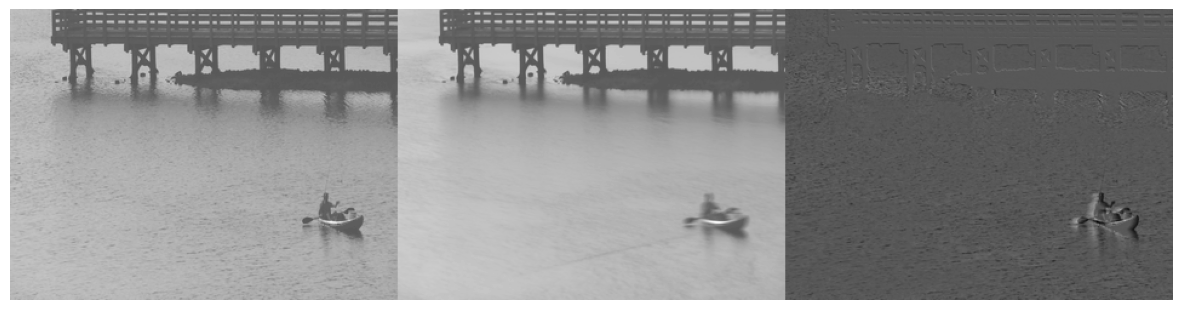

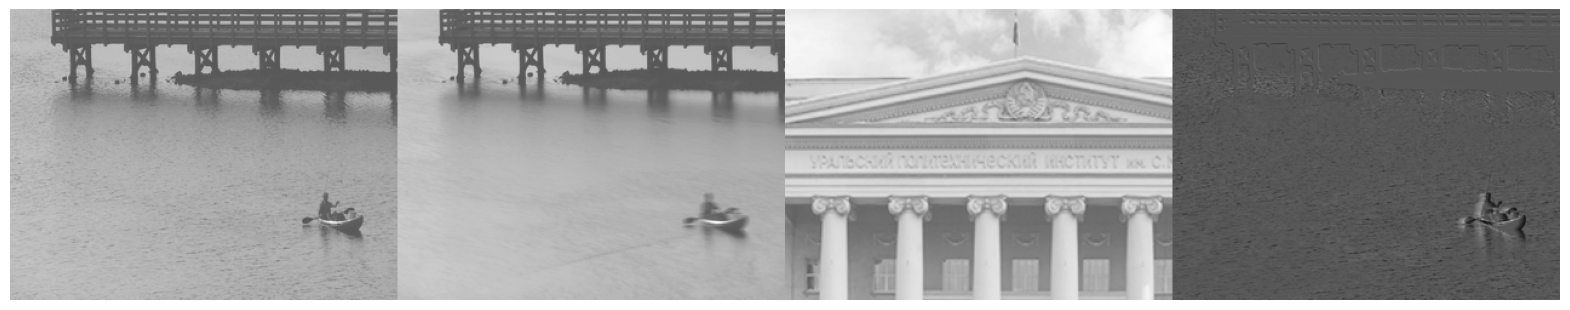

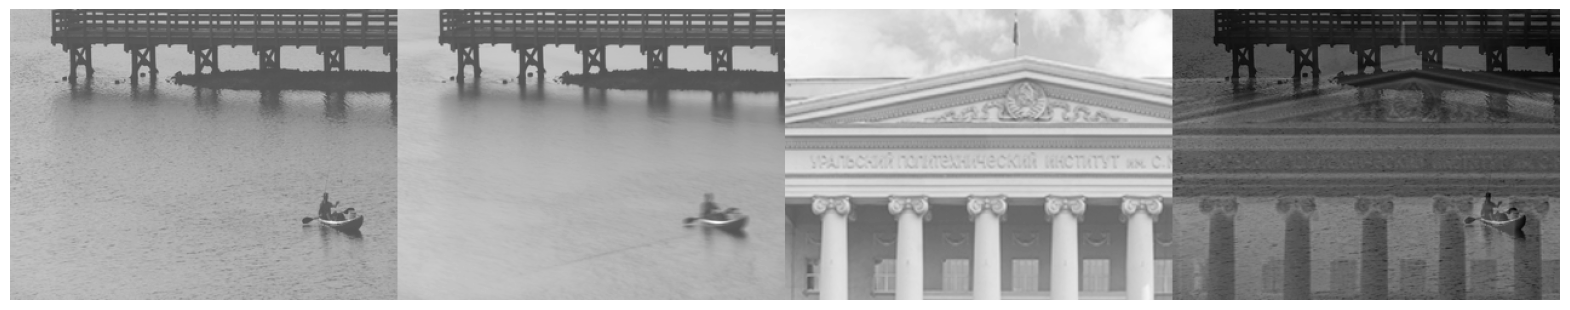

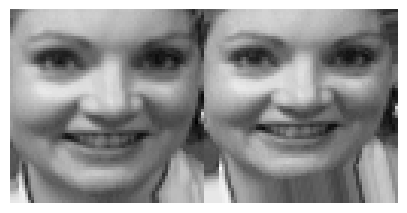

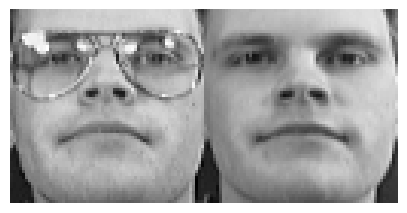

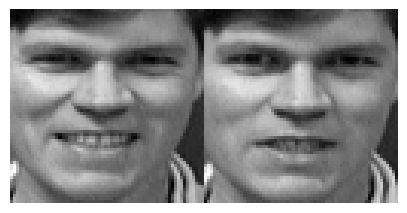

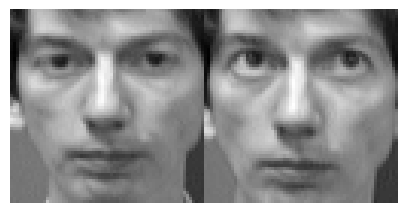

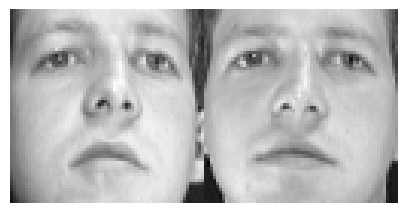

In [8]:
test_all()